# 1.MORO OPTIMIZATION

# 1.1 Generate random policies

In [1]:
n_scenarios = pow(2, 1) # Ideally a power of 2 > 1000 ... 2^10 = 1024

In [2]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1000) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Dike_Investment_Costs = functools.partial(robustness, SMALLER, 1000)
RfR_Investment_Costs = functools.partial(robustness, SMALLER, 1000)
Evacuation_Costs = functools.partial(robustness, SMALLER, 1000)
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 0.000001) #not ok



In [3]:
from problem_formulation import get_model_for_problem_formulation

model, _ = get_model_for_problem_formulation(2)

In [4]:
from ema_workbench import ema_logging, MultiprocessingEvaluator, Samplers

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,
                                            policies=4,
                                            uncertainty_sampling=Samplers.MC)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 2 scenarios * 4 policies * 1 model(s) = 8 experiments
100%|████████████████████████████████████████████| 8/8 [00:04<00:00,  1.91it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


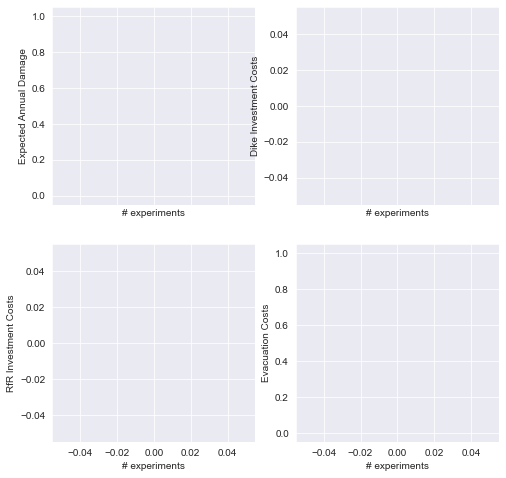

In [5]:
import matplotlib.pyplot as plt
import numpy as np
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(8,8),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1]]                             #axes[1,1]

robustness_funcs = {"Expected Annual Damage": Expected_Annual_Damage,
                    "Dike Investment Costs": Dike_Investment_Costs,
                    "RfR Investment Costs": RfR_Investment_Costs,
                    "Evacuation Costs": Evacuation_Costs,
                    "Expected Number of Deaths": Expected_Number_of_Deaths}

experiments, outcomes = results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
      
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

# 1.2 Search for candidate solutions

the fundamental problem is fine tuning the robustness functions. To do this, rather than run optimizaitons many times, why not first generate a test set with a bunch of policies, apply robustness functions and visualize the results?

This gives us much faster feedback on reasonble cutoff values. 


In [6]:
from ema_workbench.em_framework import sample_uncertainties
n_scenarios = 10
scenarios = sample_uncertainties(model, n_scenarios)
nfe = int(100)

In [7]:
from ema_workbench import (Model, CategoricalParameter,
                           ScalarOutcome, IntegerParameter, RealParameter)


In [8]:
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenarios,              
                                            policies=100)

[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 10 scenarios * 100 policies * 1 model(s) = 1000 experiments
100%|██████████████████████████████████████| 1000/1000 [07:17<00:00,  2.29it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


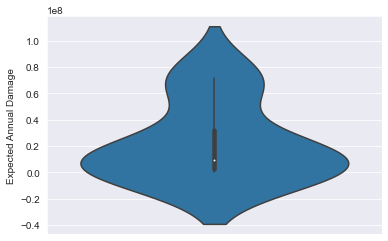

In [9]:
import pandas as pd
import seaborn as sns

data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
sns.violinplot(data=data, y='Expected Annual Damage')
plt.show()

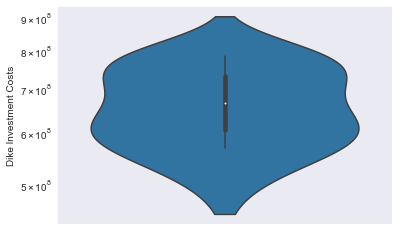

In [10]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Dike Investment Costs')
ax.set_yscale('log')
plt.show()

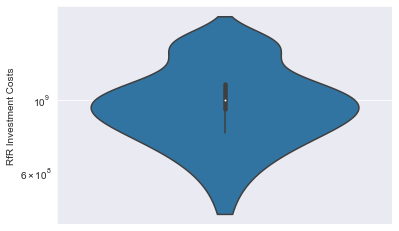

In [11]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='RfR Investment Costs')
ax.set_yscale('log')
plt.show()

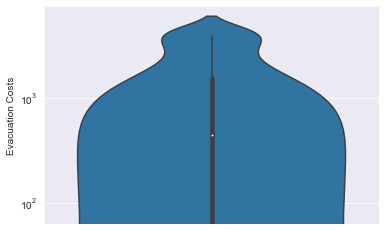

In [12]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Evacuation Costs')
ax.set_yscale('log')
plt.show()

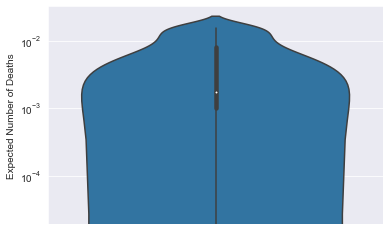

In [13]:
data = pd.DataFrame(outcomes)
data['policy'] = experiments['policy']
ax = sns.violinplot(data=data, y='Expected Number of Deaths')
ax.set_yscale('log')
plt.show()

In [14]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'

Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1e-5) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Dike_Investment_Costs = functools.partial(robustness, SMALLER, 1e4)
RfR_Investment_Costs = functools.partial(robustness, SMALLER, 6e8)
Evacuation_Costs = functools.partial(robustness, SMALLER, 6e8)
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 6e8) #not ok


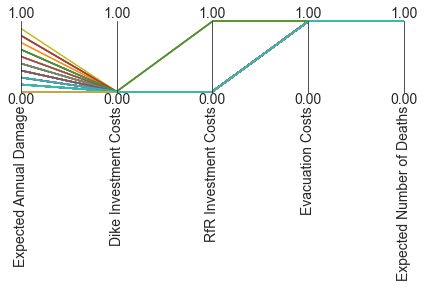

In [15]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {"Expected Annual Damage": Expected_Annual_Damage,
         "Dike Investment Costs": Dike_Investment_Costs,
         "RfR Investment Costs": RfR_Investment_Costs,
         "Evacuation Costs": Evacuation_Costs,
         "Expected Number of Deaths": Expected_Number_of_Deaths}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [17]:
from ema_workbench.em_framework.optimization import EpsilonProgress

convergence = [EpsilonProgress()]

MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE



funcs = {"Expected Annual Damage": Expected_Annual_Damage,
         "Dike Investment Costs": Dike_Investment_Costs,
         "RfR Investment Costs": RfR_Investment_Costs,
         "Evacuation Costs": Evacuation_Costs,
         "Expected Number of Deaths": Expected_Number_of_Deaths}

robustnes_functions = [ScalarOutcome('Expected Annual Damage', kind=MINIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Dike Investment Costs', kind=MINIMIZE,
                                     function=Dike_Investment_Costs),
                       ScalarOutcome('RfR Investment Costs', kind=MINIMIZE,
                                     function=RfR_Investment_Costs),
                       ScalarOutcome('Evacuation Costs', kind=MINIMIZE,
                                     function=Evacuation_Costs),
                       ScalarOutcome('Expected Number of Deaths', kind=MINIMIZE,
                                     function=Expected_Number_of_Deaths)
                       ]

epsilons=[1,]*len(funcs)  #final value of epsilon should be much lower.Just for experiment purposes is 1
nfe = 100
with MultiprocessingEvaluator(model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios,nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)


100%|████████████████████████████████████████| 100/100 [06:43<00:00,  4.04s/it]
[MainProcess/INFO] optimization completed, found 1 solutions


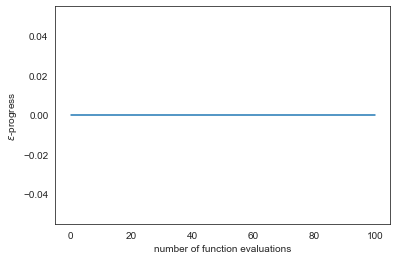

In [18]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

ax.set_xlabel('number of function evaluations')
plt.show()

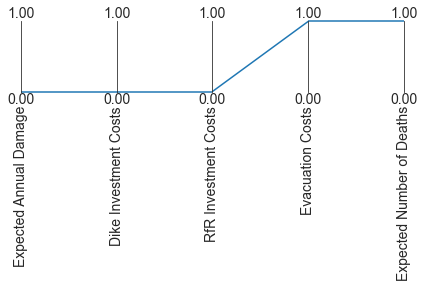

In [19]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

This is a bit better but not much. 

Now, observe the following: you are using a domain criterion as your sole measure of robustness. That is, you look at the fraction of scenarios above or below a threshold. The costs however do not vary accross scenarios. Thus this objective can only be 0 or 1. This is not particularly useful for optimization. 

We might thus want to consider another metric for costs. Why not simply use the raw costs itself?


In [20]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def costs(data):
    return data[0]/1e9 # makes numbers nicer
    
SMALLER = 'SMALLER'

Expected_Annual_Damage = functools.partial(robustness, SMALLER, 1e-5) #THOSE NUMBERS NEED TO BE SPECIFIED AGAINS
Dike_Investment_Costs = costs
RfR_Investment_Costs = costs
Evacuation_Costs = costs
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 6e8) #not ok


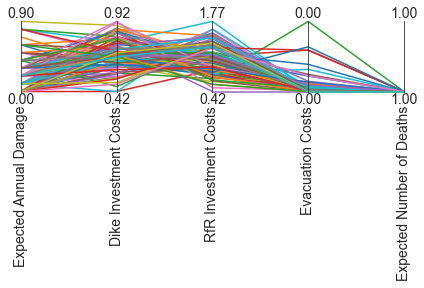

In [21]:
from ema_workbench.analysis import parcoords

experiments, outcomes = results

funcs = {"Expected Annual Damage": Expected_Annual_Damage,
         "Dike Investment Costs": Dike_Investment_Costs,
         "RfR Investment Costs": RfR_Investment_Costs,
         "Evacuation Costs": Evacuation_Costs,
         "Expected Number of Deaths": Expected_Number_of_Deaths}

total_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    logical = experiments['policy'] == policy
    
    temp_outcomes = {k:v[logical] for k,v in outcomes.items()}
    
    for k, v in temp_outcomes.items():
        score = funcs[k](v)
        scores[k] = score
    total_scores[policy] = scores

data = pd.DataFrame(total_scores).T.reset_index(drop=True)
limits = parcoords.get_limits(data)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

This already looks much nicer.

In [22]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

funcs = {"Expected Annual Damage": Expected_Annual_Damage,
         "Dike Investment Costs": Dike_Investment_Costs,
         "RfR Investment Costs": RfR_Investment_Costs,
         "Evacuation Costs": Evacuation_Costs,
         "Expected Number of Deaths": Expected_Number_of_Deaths}

robustnes_functions = [ScalarOutcome('Expected Annual Damage', kind=MINIMIZE,
                                     function=Expected_Annual_Damage),
                       ScalarOutcome('Dike Investment Costs', kind=MINIMIZE,
                                     function=Dike_Investment_Costs),
                       ScalarOutcome('RfR Investment Costs', kind=MINIMIZE,
                                     function=RfR_Investment_Costs),
                       ScalarOutcome('Evacuation Costs', kind=MINIMIZE,
                                     function=Evacuation_Costs),
                       ScalarOutcome('Expected Number of Deaths', kind=MINIMIZE,
                                     function=Expected_Number_of_Deaths)
                       ]

In [23]:
# we have to change the plausible max for total investment costs
convergence = [EpsilonProgress()]

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, scenarios, nfe=nfe,
                                                     convergence=convergence, epsilons=epsilons)


100%|████████████████████████████████████████| 100/100 [06:54<00:00,  4.14s/it]
[MainProcess/INFO] optimization completed, found 5 solutions


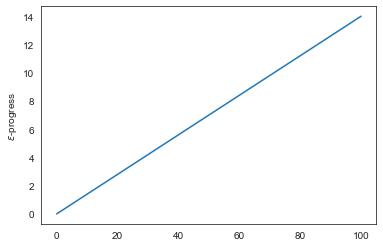

In [24]:
fig, ax = plt.subplots()
ax.plot(convergence.nfe, convergence.epsilon_progress)
ax.set_ylabel('$\epsilon$-progress')

plt.show()